## MNIST [Modified National Institute of Standards and Technology] dataset is a foundational dataset in ML containing (60000,10000) grayscale images [training and testing]

In [4]:
import numpy as np
import pandas as pd
import sklearn
np.random.seed(42)

In [5]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X,y=mnist['data'],mnist['target']
X.shape
#it has 784 feature [28px*28px]

(70000, 784)

In [4]:
y.shape

(70000,)

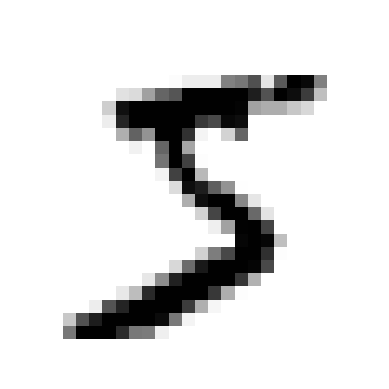

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=mpl.cm.binary)#show in black and white
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [8]:
#The output is string but i expect number so let's cast
y=y.astype(np.uint8)#astype(int) are the same but the used is 8 bits not 64
y[0]

np.uint8(5)

In [9]:
#Split data [60000 train and 10000 test]
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

## Training a Binary Classifier

In [10]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

### SGDClassifier:trains a model one sample at a time, instead of training on the whole dataset at once

In [11]:
from sklearn.linear_model import SGDClassifier
#model will train up to 1000 iterations ,earlystop if the improvement become lessthan 0.001
sgd_clf=SGDClassifier(max_iter=1000,tol=1e-3,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

## Performace Measures

In [12]:
# Measure Accuracy using Cross Validation (I need more control so i will implemnt it my self)
#      Manual approach
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds=StratifiedKFold(n_splits=3,shuffle=True,random_state=42)
for train_index,test_index in skfolds.split(X_train,y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds=X_train[train_index]
  y_train_folds=y_train_5[train_index]
  X_test_fold=X_train[test_index]
  y_test_fold=y_train_5[test_index]

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred))


0.9669
0.91625
0.96785


In [13]:
# Automatically calculate it
from sklearn.model_selection import cross_val_score
scores=cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')
print(scores)

[0.95035 0.96035 0.9604 ]


In [14]:
#Dummy classifier used for baseline to compare my real model [classifier that make prediction withou learning from data]

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [15]:
#The accuracy for not 5 is 90% so the accuracy alone is misleading on imbalanced datasets
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

A much better way to evaluate the performance of a classifier. it is a table that summarizes how well a classification model is performing. It compares the predicted labels vs the true labels and gives a clear picture of errors and correct predictions.

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

| | Predicted: not-5 | Predicted: 5 |
| :--- | :---: | :---: |
| **Actual: not-5** | value (TN) | value (FP) |
| **Actual: 5** | value (FN) | value (TP) |

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

A perfect classifier would have only **TN** and **TP** 

In [18]:
#Pretend we reached perfection
y_train_perfect_predections=y_train_5
confusion_matrix(y_train_5,y_train_perfect_predections)

array([[54579,     0],
       [    0,  5421]])

### Percision and Recall and F1

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

In [19]:
from sklearn.metrics import precision_score
Precison=precision_score(y_train_5,y_train_pred)
print(Precison)
#Manually calculated
cm=confusion_matrix(y_train_5,y_train_pred)
precision_cm=cm[1, 1] / (cm[0, 1] + cm[1, 1])
print(precision_cm)

0.8370879772350012
0.8370879772350012


$$
\text{Recall} =  \frac{TP}{TP + FN}
$$

In [20]:
from sklearn.metrics import recall_score
recall_score(y_train_5,y_train_pred)

0.6511713705958311

$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
$$

In [21]:
from sklearn.metrics import f1_score 
f1_score(y_train_5,y_train_pred)

0.7325171197343847

## Percision /Recall Trade-off

when you can't maximize both at the same time
* High precision,low recall:
  * Model rarely says a digit is 5
  * Most predicted 5s are correct, but it misses many real 5s
* Hight recall,low precision:
  * Model predicts 5 for many digits
  * Most 5s are detected, but many non-5s are incorrectly predicted as 5

In order to understand it you have to visualize it using Precision-Recal Curve

In [22]:
#decision_function()=>return the score for each instance
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [25]:
#how to decide which threeshold to use
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,
                           method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

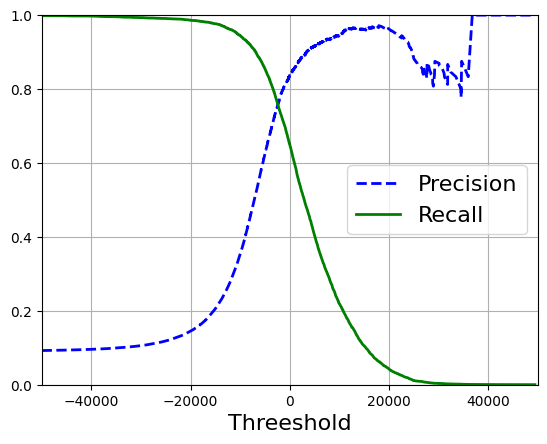

In [27]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
  plt.plot(thresholds,precisions[:-1],"b--",label="Precision",linewidth=2)
  plt.plot(thresholds,recalls[:-1],"g-",label="Recall",linewidth=2)
  plt.legend(loc="center right",fontsize=16)
  plt.xlabel("Threeshold",fontsize=16)
  plt.grid(True)
  plt.axis([-50000,50000,0,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

### Choosing a threshold for high precision

In [28]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)] #Select precisions >90
threshold_90_precision

np.float64(3370.0194991439557)

In [29]:
y_train_pred_90=(y_scores>=threshold_90_precision)
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC [Receiver operating charactristic]
another common tool used in binary classification similar to the precision/recall curve

In [31]:
#FPR=>False positive rate 
#TPR=>True positive rate [recall]
from sklearn.metrics import roc_curve
fpr,tpr,thresholds =roc_curve(y_train_5,y_scores)

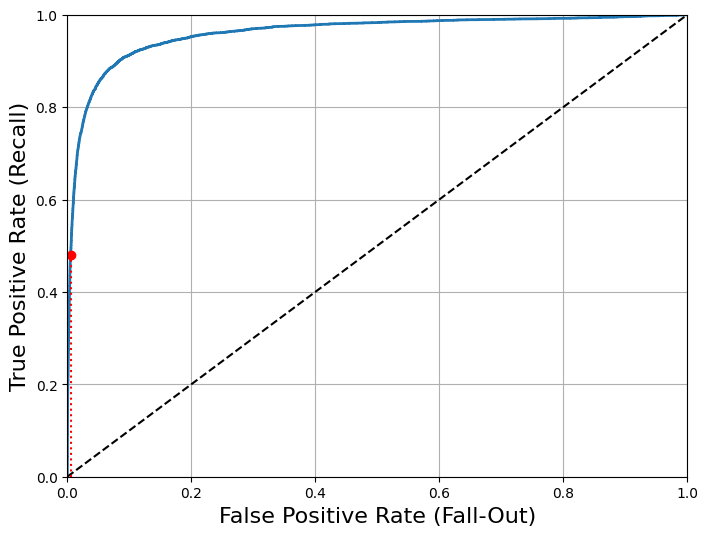

In [32]:
def plot_roc_curve(fpr,tpr,label=None):
  plt.plot(fpr,tpr,linewidth=2,label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate (Fall-Out)',fontsize=16)
  plt.ylabel('True Positive Rate (Recall)',fontsize=16)
  plt.grid(True)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
fpr_90=fpr[np.argmax(tpr>=recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

In [33]:
#Calculate the ROC Score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

np.float64(0.9604938554008616)

### Compare ROC and ROC AUC Score to SGDClassifier Using [RandomForestClassifier]

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(n_estimators=100,random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,
                                  method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

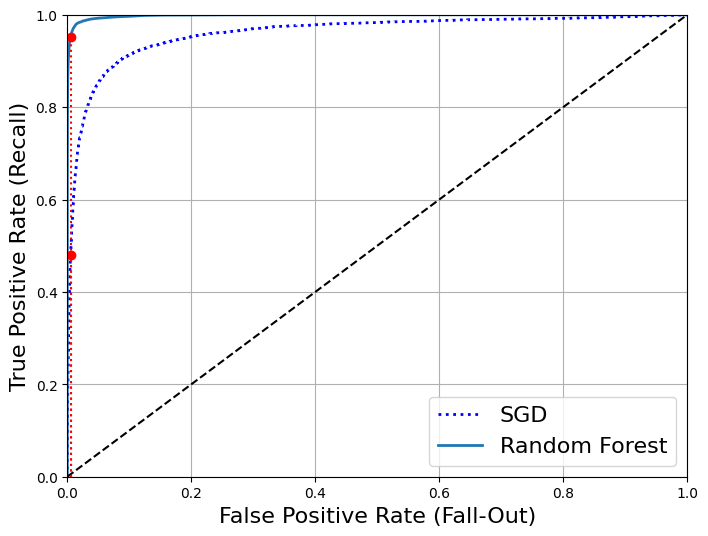

In [36]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [37]:
roc_auc_score(y_train_5,y_scores_forest)

np.float64(0.9983436731328145)

In [38]:
#take too much time
y_train_pred_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
precision_score(y_train_5,y_train_pred_forest)

0.9905083315756169

In [39]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### Multiclass Classification

Can distinguish between more than 2 classes

In [40]:
#It trained 45 binary classifier to predict the some-digit
from sklearn.svm import SVC
svm_clf=SVC(gamma="auto",random_state=42)
svm_clf.fit(X_train[:1000],y_train[:1000])
svm_clf.predict([some_digit])#5

array([5], dtype=uint8)

In [41]:
#Get scores and we will find the max score is corresponding to class 5
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [42]:
np.argmax(some_digit_scores)

np.int64(5)

In [43]:
# OVR classes 
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

<p align="center"><b>Too Much Time </b></p>


In [ ]:
#scikit-learn uses OVO by deafult but i can change it to be OVR by:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)

In [ ]:
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [16]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

**It takes 18.26 mins**

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

In [ ]:
knn_clf.predict([some_digit])